In [15]:
import torch
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import time

## Data Loader

In [16]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Tạo thư mục để lưu ảnh
# images_dir = './saved_images'
# os.makedirs(images_dir, exist_ok=True)

batch_size = 32
trainset = torchvision.datasets.CIFAR10(root='./saved_images', train=True, download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./saved_images', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
)


Files already downloaded and verified
Files already downloaded and verified


In [17]:
print(len(trainloader))
print(len(testloader))

1563
313


## Visualization

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

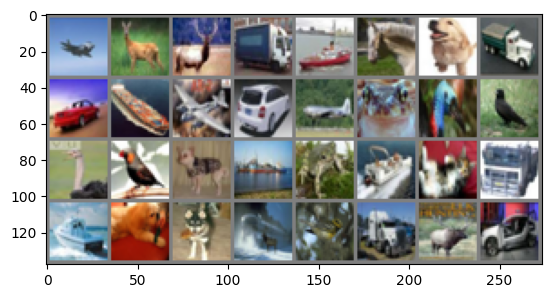

In [19]:
imshow(torchvision.utils.make_grid(images))

In [20]:
print(' '.join(f'{classes[j]}' for j in labels))

plane deer deer truck ship horse dog truck car ship plane car plane frog bird bird bird bird dog ship frog ship cat truck ship dog dog deer bird truck deer car


## Define Residual Neural Network

In [21]:
import torch
from torch import nn
from torchsummary import summary

class ResidualBlockPytorch(nn.Module):
    def __init__(self, num_channels, output_channels, strides=1, is_used_conv11=False, **kwargs):
        super(ResidualBlockPytorch, self).__init__(**kwargs)
        self.is_used_conv11 = is_used_conv11
        self.conv1 = nn.Conv2d(num_channels, num_channels, padding=1,
                               kernel_size=3, stride=1)
        self.batch_norm = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels, num_channels, padding=1,
                               kernel_size=3, stride=1)
        if self.is_used_conv11:
            self.conv3 = nn.Conv2d(num_channels, num_channels, padding=0,
                               kernel_size=1, stride=1)
        # Last convolutional layer to reduce output block shape.
        self.conv4 = nn.Conv2d(num_channels, output_channels, padding=0,
                               kernel_size=1, stride=strides)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        if self.is_used_conv11:
            Y = self.conv3(X)
        else:
            Y = X
        X = self.conv1(X)
        X = self.relu(X)
        X = self.batch_norm(X)
        X = self.relu(X)
        X = self.conv2(X)
        X = self.batch_norm(X)
        X = self.relu(X+Y)
        X = self.conv4(X)
        return X


class ResNet18PyTorch(nn.Module):
    def __init__(self, residual_blocks, output_shape):
        super(ResNet18PyTorch, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7,
                               stride=2, padding=3)
        self.batch_norm = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.residual_blocks = nn.Sequential(*residual_blocks)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.global_avg_pool = nn.Flatten()
        self.dense = nn.Linear(in_features=512, out_features=output_shape)

    def forward(self, X):
        X = self.conv1(X)
        X = self.batch_norm(X)
        X = self.relu(X)
        X = self.max_pool(X)
        X = self.residual_blocks(X)
        X = self.global_avg_pool(X)
        X = self.dense(X)
        return X

residual_blocks = [
    # Two start conv mapping
    ResidualBlockPytorch(num_channels=64, output_channels=64, strides =2, is_used_conv11=False),
    ResidualBlockPytorch(num_channels=64, output_channels=64, strides=2, is_used_conv11=False),
    # Next three [conv mapping + identity mapping]
    ResidualBlockPytorch(num_channels=64, output_channels = 128, strides = 2, is_used_conv11=True),
    ResidualBlockPytorch(num_channels=128, output_channels=128, strides=2, is_used_conv11=False),
    ResidualBlockPytorch(num_channels=128, output_channels=256, strides=2, is_used_conv11=True),
    ResidualBlockPytorch(num_channels=256, output_channels=256, strides=2, is_used_conv11=False),
    ResidualBlockPytorch(num_channels=256, output_channels=512, strides=2, is_used_conv11=False),
    ResidualBlockPytorch(num_channels= 512, output_channels=512, strides=2, is_used_conv11=False)
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda:1' if torch.cuda.device_count() > 1 else 'cpu')

# device = torch.cuda.current_device()
ptmodel = ResNet18PyTorch(residual_blocks, output_shape=10)
ptmodel = ptmodel.to(device)
summary(ptmodel, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,472
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,928
              ReLU-6             [-1, 64, 7, 7]               0
       BatchNorm2d-7             [-1, 64, 7, 7]             128
              ReLU-8             [-1, 64, 7, 7]               0
            Conv2d-9             [-1, 64, 7, 7]          36,928
      BatchNorm2d-10             [-1, 64, 7, 7]             128
             ReLU-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 4, 4]           4,160
ResidualBlockPytorch-13             [-1, 64, 4, 4]               0
           Conv2d-14             [-1

### Build EarlyStopping

In [22]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.Inf
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                print("Early stopping")
                self.early_stop = True
        return self.early_stop

### **Optimize**
* Batch_size = 32
* lr = 0.01

In [23]:
# Test GPU
torch.cuda.is_available()

True

In [24]:
!nvidia-smi

Mon Mar 25 13:38:56 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:17:00.0 Off |                  Off |
| 30%   48C    P2    61W / 230W |   1961MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:18:00.0 Off |                  Off |
| 30%   

In [25]:
def acc(output, label):
    return (torch.argmax(output, axis=1)==label).float().mean()

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ptmodel.parameters(), lr=1.15E-02, momentum=0.9)

* Phải extract loss, acc, val_acc 
* So sánh L1, L2, Dropout, earling stopping, 

In [24]:
acc_train_list = []
acc_val_list = []
train_losses = []
valid_losses = []
count_early = 0

early_stopping = EarlyStopping(patience=5, min_delta=0.001)

for epoch in range(35):
    ptmodel.train()
    total_loss = 0.0
    train_acc = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = ptmodel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        train_acc += acc(outputs, labels).item()

#     ptmodel.eval()
    with torch.no_grad():
        valid_loss = 0.0
        valid_acc = 0.0
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = ptmodel(inputs)
            valid_loss += criterion(outputs, labels).item()
            valid_acc += acc(outputs, labels).item()

    avg_train_loss = total_loss / len(trainloader)
    avg_valid_loss = valid_loss / len(testloader)
    avg_train_acc = train_acc / len(trainloader)
    avg_valid_acc = valid_acc / len(testloader)

    train_losses.append(avg_train_loss)
    valid_losses.append(avg_valid_loss)
    acc_train_list.append(avg_train_acc)
    acc_val_list.append(avg_valid_acc)

    print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.3f}, Train Acc: {avg_train_acc:.2f}, '
          f'Valid Loss: {avg_valid_loss:.3f}, Valid Acc: {avg_valid_acc:.2f}')
    
    count_early = epoch - 5
    if early_stopping(avg_valid_loss):
        print("Stopping early due to no improvement")
        break

print('Finished Training')

Epoch 1: Train Loss: 1.870, Train Acc: 0.28, Valid Loss: 1.634, Valid Acc: 0.38
Epoch 2: Train Loss: 1.570, Train Acc: 0.42, Valid Loss: 1.501, Valid Acc: 0.45
Epoch 3: Train Loss: 1.407, Train Acc: 0.49, Valid Loss: 1.360, Valid Acc: 0.51
Epoch 4: Train Loss: 1.263, Train Acc: 0.55, Valid Loss: 1.276, Valid Acc: 0.55
Epoch 5: Train Loss: 1.156, Train Acc: 0.59, Valid Loss: 1.147, Valid Acc: 0.59
Epoch 6: Train Loss: 1.074, Train Acc: 0.62, Valid Loss: 1.078, Valid Acc: 0.63
Epoch 7: Train Loss: 1.008, Train Acc: 0.65, Valid Loss: 1.045, Valid Acc: 0.65
Epoch 8: Train Loss: 0.951, Train Acc: 0.68, Valid Loss: 1.037, Valid Acc: 0.64
Epoch 9: Train Loss: 0.904, Train Acc: 0.69, Valid Loss: 1.029, Valid Acc: 0.66
Epoch 10: Train Loss: 0.851, Train Acc: 0.71, Valid Loss: 0.981, Valid Acc: 0.67
Epoch 11: Train Loss: 0.815, Train Acc: 0.72, Valid Loss: 0.935, Valid Acc: 0.69
Epoch 12: Train Loss: 0.773, Train Acc: 0.74, Valid Loss: 0.930, Valid Acc: 0.70
Epoch 13: Train Loss: 0.734, Train Ac

### Result
Epoch 25: Train Loss: 0.507, Train Acc: 0.83, Valid Loss: 0.996, Valid Acc: 0.70

In [35]:
# print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.3f}, Train Acc: {avg_train_acc:.2f}, '
#       f'Valid Loss: {avg_valid_loss:.3f}, Valid Acc: {avg_valid_acc:.2f}')

Epoch 25: Train Loss: 0.507, Train Acc: 0.83, Valid Loss: 0.996, Valid Acc: 0.70


**Save model**

In [34]:
# torch.save(ptmodel.state_dict(), 'model_state.pth')

In [ ]:
# Khởi tạo lại mô hình giống như khi bạn huấn luyện
model = TheModelClassYouUsed()  # Thay thế TheModelClassYouUsed bằng lớp mô hình cụ thể của bạn
model.load_state_dict(torch.load('model_state.pth'))
model.eval()  # Đặt mô hình vào chế độ đánh giá nếu không huấn luyện tiếp

In [44]:
def loss_fig(x, y, count):
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(np.arange(len(x)),x, label='Training Loss')
    plt.plot(np.arange(len(x)),y,label='Validation Loss')

    # find position of lowest validation loss
    # minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(count, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
#     plt.ylim([0,])
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
#     fig.savefig('loss_plot_reg_lr0.001.png', bbox_inches='tight')

In [30]:
acc_val_lists = []
for i in range(len(acc_val_list)):
    acc_val_lists.append(acc_val_list[i].item())

In [35]:
def acc_fig(x, y, count):
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(np.arange(len(x)),x, label='Training Loss')
    plt.plot(np.arange(len(x)),y,label='Validation Loss')

    # find position of lowest validation loss
    # minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(count, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('acc')
    # plt.ylim(0, 0.5) # consistent scale
    # plt.xlim(0, len(train_loss)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    # plt.tight_layout()
    plt.show()
#     fig.savefig('acc_plot_reg_lr0.001.png', bbox_inches='tight')

# Note:

* Early Stopping in loss => optimize accuracy in trainset, testset no change (high bias, low variance, train: 96.95, val:0.71"
* Early Stopping in acc val 

## Turning Learning rate

Giảm tốc độ học đi 0.9 qua mỗi epoch

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma=0.9)
scheduler.step()

scheduler2 giảm lr ở các cột mốc cố định giả sử epoch thứ 30 thì giảm lr = lr*0.1

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler1 = ExponentialLR(optimizer, gamma=0.9)
scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

In [6]:
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.001,
   'momentum': 0.9,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'params': [0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27,
    28,
    29,
    30,
    31,
    32,
    33,
    34,
    35,
    36,
    37,
    38,
    39,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    48,
    49,
    50,
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    58,
    59,
    60,
    61,
    62,
    63,
    64,
    65,
    66,
    67,
    68,
    69,
    70,
    71,
    72,
    73]}]}

In [4]:
from torch_lr_finder import LRFinder
from torch import optim
from torch import nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ptmodel.parameters(), momentum=0.9)

/data2/chinh/anaconda3/envs/An/lib/python3.11/site-packages/torch_lr_finder/lr_finder.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [11]:
lr_finder = LRFinder(ptmodel, optimizers, criterion, device="cuda" if torch.cuda.is_available() else "cpu")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100, step_mode="exp")

 45%|████▌     | 45/100 [00:01<00:01, 36.42it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 1.15E-02


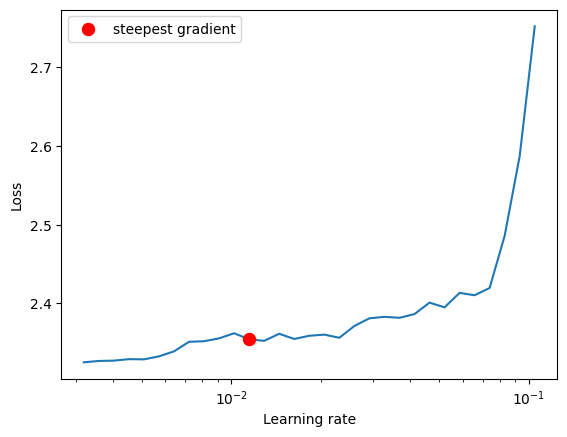

(<Axes: xlabel='Learning rate', ylabel='Loss'>, 0.011497569953977358)

In [12]:
lr_finder.plot()

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ptmodel.parameters(),lr=0.001, weight_decay=5e-4)
# optimizer = optim.SGD(ptmodel.parameters(), lr=1.15E-02, momentum=0.9, weight_decay=5e-4)


In [14]:
1.15E-02

0.0115

# Regularization

In [46]:
acc_train_list = []
acc_val_list = []
train_losses = []
valid_losses = []
count_early = 0

early_stopping = EarlyStopping(patience=5, min_delta=0.001)

for epoch in range(50):
    ptmodel.train()
    total_loss = 0.0
    train_acc = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = ptmodel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        train_acc += acc(outputs, labels).item()

#     ptmodel.eval()
    with torch.no_grad():
        valid_loss = 0.0
        valid_acc = 0.0
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = ptmodel(inputs)
            valid_loss += criterion(outputs, labels).item()
            valid_acc += acc(outputs, labels).item()

    avg_train_loss = total_loss / len(trainloader)
    avg_valid_loss = valid_loss / len(testloader)
    avg_train_acc = train_acc / len(trainloader)
    avg_valid_acc = valid_acc / len(testloader)

    train_losses.append(avg_train_loss)
    valid_losses.append(avg_valid_loss)
    acc_train_list.append(avg_train_acc)
    acc_val_list.append(avg_valid_acc)

    print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.3f}, Train Acc: {avg_train_acc:.2f}, '
          f'Valid Loss: {avg_valid_loss:.3f}, Valid Acc: {avg_valid_acc:.2f}')
    
    count_early = epoch - 5
    if early_stopping(avg_valid_loss):
        print("Stopping early due to no improvement")
        break

print('Finished Training')

Epoch 1: Train Loss: 0.616, Train Acc: 0.79, Valid Loss: 0.906, Valid Acc: 0.71
Epoch 2: Train Loss: 0.611, Train Acc: 0.80, Valid Loss: 0.888, Valid Acc: 0.72
Epoch 3: Train Loss: 0.589, Train Acc: 0.80, Valid Loss: 0.894, Valid Acc: 0.72
EarlyStopping counter: 1 out of 5
Epoch 4: Train Loss: 0.580, Train Acc: 0.81, Valid Loss: 0.898, Valid Acc: 0.72
EarlyStopping counter: 2 out of 5
Epoch 5: Train Loss: 0.564, Train Acc: 0.81, Valid Loss: 0.874, Valid Acc: 0.72
Epoch 6: Train Loss: 0.552, Train Acc: 0.82, Valid Loss: 0.905, Valid Acc: 0.72
EarlyStopping counter: 1 out of 5
Epoch 7: Train Loss: 0.542, Train Acc: 0.82, Valid Loss: 0.868, Valid Acc: 0.73
Epoch 8: Train Loss: 0.529, Train Acc: 0.82, Valid Loss: 0.897, Valid Acc: 0.72
EarlyStopping counter: 1 out of 5
Epoch 9: Train Loss: 0.520, Train Acc: 0.83, Valid Loss: 0.932, Valid Acc: 0.72
EarlyStopping counter: 2 out of 5
Epoch 10: Train Loss: 0.512, Train Acc: 0.83, Valid Loss: 0.901, Valid Acc: 0.73
EarlyStopping counter: 3 out 

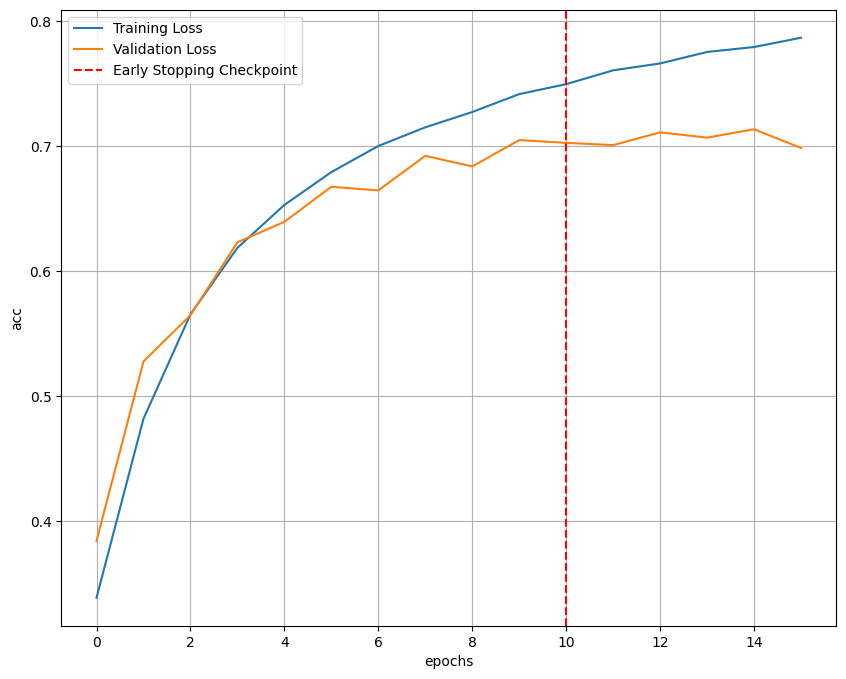

In [34]:
acc_fig(acc_train_list, acc_val_list, count_early)

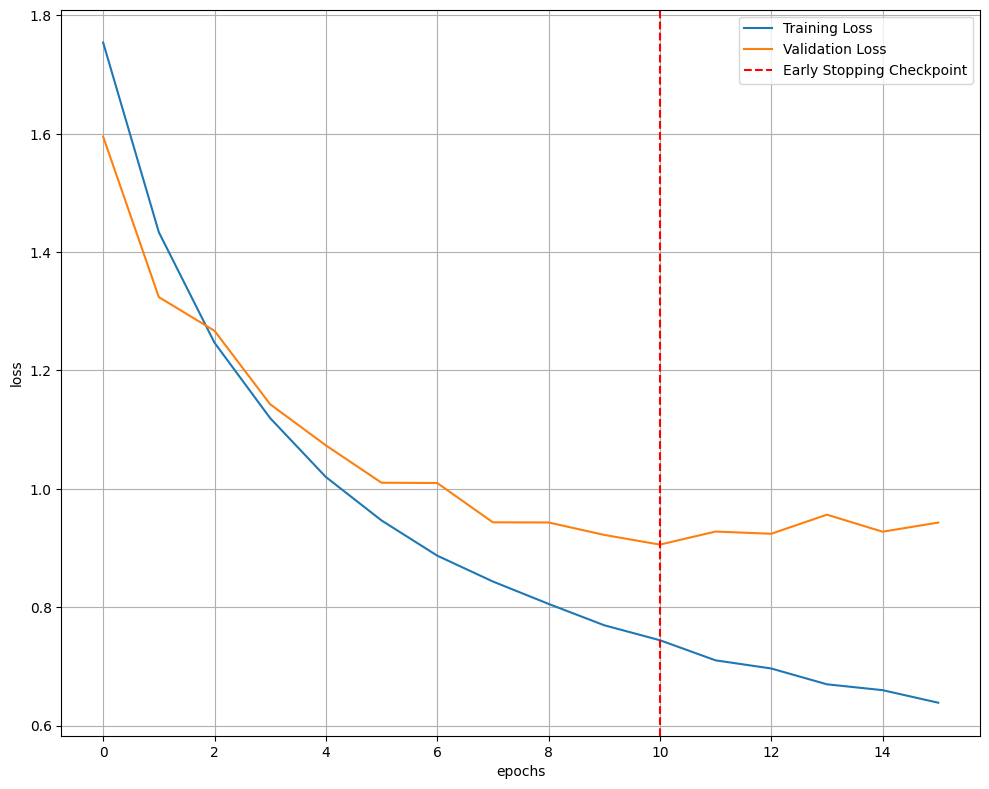

In [45]:
loss_fig(train_losses, valid_losses, count_early)